In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import timeit
import datetime
import time
import pprint
import itertools
import pickle
import sklearn
import dask
import os
os.chdir('/mnt/t48/bighomes-active/sfeng/patentdiffusion/')
import fastparquet
seed = 3
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import h5py
import collections
import dask.dataframe as dd

/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Code from:
- https://sfengc7.stern.nyu.edu:8888/notebooks/patentdiffusion/201807Results/MutualCitations/3c-NewTerms-Analysis-v3.ipynb
- https://sfengc7.stern.nyu.edu:8888/notebooks/patentdiffusion/201807Results/MutualCitations/3a-NewTerms-v1.ipynb

In [2]:
nt = fastparquet.ParquetFile("DataStore/2018-06/newterm_pairs_sim_0620.parq").\
to_pandas(["lead_pat", "term", "firstyear", "count"]).drop_duplicates().rename(columns={"lead_pat":"patent"})
pdf = fastparquet.ParquetFile("RawData/Cleaned/patent_loc_unique_us_0628.parq").to_pandas(\
                            ["patent", "gyear", "inv_msa", "primclass", "naics_name", "title"])
print(len(nt))
nt = nt.merge(pdf, how="left", on="patent")
del(pdf)
print(len(nt))

4421
4421


In [3]:
# Get application data from HBS invpat
ip = pd.read_pickle("RawData/HBSPatData/invpat_us_7509_loc_unique.pkl")[["patent", "appdate"]]
nt = nt.merge(ip, how="left", on="patent")
del(ip)
print(len(nt))

# Change appdate to datetime
nt["appdate"] = pd.to_datetime(nt["appdate"])

4421


In [4]:
from sklearn.metrics import pairwise
dms = ["ldavecs", "docvecs"]
# dms = ["docvecs"]

pat_dict = fastparquet.ParquetFile("RawData/Cleaned/patabs7615_us_no_dup.parq").to_pandas(["patent"])["patent"].tolist()
pat_dict = dict(zip(pat_dict, range(len(pat_dict))))

out = {}
for dm in dms:
    pm = fastparquet.ParquetFile("DataStore/2018-07-P2/ML/{0}_pats_0712.parq".format(dm))\
        .to_pandas().values
    sim = pd.DataFrame()
    
    # Make sure patent is in the dictionary
    ntg = nt.loc[nt["patent"].isin(pat_dict.keys()), ["patent", "term"]].groupby("term")
    for n,g in ntg:
        m = pm[[pat_dict[p] for p in g["patent"].tolist()]]
        cs1 = pairwise.cosine_similarity(m)
        # Upper triangular indices
        ut = np.triu_indices(np.shape(cs1)[0])
        # Set equal to nan
        cs1[ut] = np.nan
        
        cs = pd.DataFrame(cs1).unstack().reset_index()
        # Drop missing values which are duplicated
        cs = cs.loc[cs[0].notnull()]
        cs = cs.rename(columns={0: "sim_{0}".format(dm)})
        # Get patent pairs
        cs["tp"] = cs["level_0"].map(dict(zip(range(len(g["patent"].tolist())), g["patent"].tolist())))
        cs["op"] = cs["level_1"].map(dict(zip(range(len(g["patent"].tolist())), g["patent"].tolist())))
        # Drop duplicates
        cs = cs.drop_duplicates().drop(["level_0", "level_1"], 1)

        sim = sim.append(cs, ignore_index=True)
    out[dm] = sim

In [6]:
sim = out["ldavecs"].merge(out["docvecs"], how="left", on = ["tp", "op"])

# Merge with data
sim = sim.merge(nt.add_prefix("tp_"), how = "left", left_on = "tp", right_on = "tp_patent").drop("tp_patent",1)
sim = sim.merge(nt.add_prefix("op_"), how = "left", left_on = "op", right_on = "op_patent").drop("op_patent",1)

# MSA Match
sim["inv_msa_match"] = (sim["tp_inv_msa"] == sim["op_inv_msa"])

In [7]:
print(len(sim))

2002814

In [8]:
fastparquet.write("DataStore/2018-08/newterms_pats_sim_0903.parq", sim, compression="GZIP")

### Citations

1. See if "later" patent cites earlier
2. Clean self citations
3. Number of common citations
4. Number of cited patents in each respective citing *inv_msa*

In [18]:
# # Add list of cited patents for each
# cit = dd.read_parquet("RawData/Cleaned/cit_0628.parq")

# %time c2 = cit[cit["citing"].isin(nt["patent"])].compute()
# del(cit)

# # See if there's a direct citation
# %time c3 = {n:g["cited"].tolist() for n,g in c2.groupby("citing")}
# %time sim["direct_cite"] = [True if tp in c3.get(op, []) else False for tp, op in zip(sim["tp"], sim["op"])]
# del(c3)


# # Add assignees for each patent
# asgs = pickle.load(open("RawData/Cleaned/patent_assignee_dict_0628.pkl", "rb"))

# # Remove self-citations
# %time asg_match = (set(asgs.get(cited, [])).intersection(asgs.get(citing, [])) for cited, citing \
#                    in zip(c2["cited"], c2["citing"]))
# %time asg_match = [len(i) for i in asg_match]
# del(asgs)

# c2["asg_match"] = asg_match
# c2 = c2.loc[c2["asg_match"] == 0]
# c2 = c2.drop("asg_match", 1)

# Add location
pdf = fastparquet.ParquetFile("RawData/Cleaned/patent_loc_unique_us_0628.parq")\
.to_pandas(["patent", "inv_msa"])
c2["cited_inv_msa"] = c2["cited"].map(dict(zip(pdf["patent"], pdf["inv_msa"])))
c2["citing_inv_msa"] = c2["citing"].map(dict(zip(pdf["patent"], pdf["inv_msa"])))
del(pdf)

In [21]:
# Number of common citations
%time c3 = {n:g["cited"].tolist() for n,g in c2.groupby("citing")}

%time num_common_cites = (set(c3.get(tp, [])).intersection(set(c3.get(op, []))) for tp, op in zip(sim["tp"], sim["op"]))
%time sim["num_common_cites"] = [len(i) for i in num_common_cites]

CPU times: user 2.45 s, sys: 0 ns, total: 2.45 s
Wall time: 2.45 s
CPU times: user 88.9 ms, sys: 0 ns, total: 88.9 ms
Wall time: 89.2 ms
CPU times: user 5.28 s, sys: 0 ns, total: 5.28 s
Wall time: 5.32 s


In [23]:
# Number of non-self-citations for each
sim["tp_num_cites"] = [len(c3.get(p, [])) for p in sim["tp"]]
sim["op_num_cites"] = [len(c3.get(p, [])) for p in sim["op"]]
del(c3)

In [28]:
# Number of local cites for each
c2 = c2.loc[(c2["cited_inv_msa"] == c2["citing_inv_msa"])]

%time c3 = {n:g["cited"].tolist() for n,g in c2.groupby("citing")}
sim["tp_num_cites_inv_msa"] = [len(c3.get(p, [])) for p in sim["tp"]]
sim["op_num_cites_inv_msa"] = [len(c3.get(p, [])) for p in sim["op"]]

del(c2, c3)

CPU times: user 570 ms, sys: 0 ns, total: 570 ms
Wall time: 537 ms


In [30]:
# Percentage of local cites
sim["tp_pct_cite_msa_match"] = sim["tp_num_cites_inv_msa"]/sim["tp_num_cites"]
sim["op_pct_cite_msa_match"] = sim["op_num_cites_inv_msa"]/sim["op_num_cites"]

In [31]:
fastparquet.write("DataStore/2018-08/newterms_pats_sim_cite_0903.parq", sim, compression="GZIP")

### Data description

First drop pairs from the same assignee

In [5]:
sim = fastparquet.ParquetFile("DataStore/2018-08/newterms_pats_sim_cite_0903.parq").to_pandas()
print(len(sim))

2002814


In [6]:
# Number of common citations as percentage of target's citations
sim["tp_pct_common_cites"] = sim["num_common_cites"]/sim["tp_num_cites"]
sim["op_pct_common_cites"] = sim["num_common_cites"]/sim["op_num_cites"]

In [5]:
# Add assignees for each patent
%time asgs = pickle.load(open("RawData/Cleaned/patent_assignee_dict_0628.pkl", "rb"))

# Remove self-citations
%time asg_match = (set(asgs.get(tp, [])).intersection(asgs.get(op, [])) for tp,op \
                   in zip(sim["tp"], sim["op"]))
%time asg_match = [len(i) for i in asg_match]
del(asgs)

sim["asg_match"] = asg_match
sim = sim.loc[sim["asg_match"] == 0]
sim = sim.drop("asg_match", 1)

CPU times: user 23.4 s, sys: 9.34 s, total: 32.7 s
Wall time: 36.6 s
CPU times: user 88.7 ms, sys: 88.7 ms, total: 177 ms
Wall time: 178 ms
CPU times: user 4.14 s, sys: 0 ns, total: 4.14 s
Wall time: 4.18 s


In [6]:
# Drop gan
sim = sim.loc[~(sim["tp_term"] == "gan") & ~(sim["op_term"] == "gan")]
print(len(sim))

888533


In [147]:
print(np.percentile(sim["sim_docvecs"], 99), np.percentile(sim["sim_docvecs"], 90),
      np.percentile(sim["sim_docvecs"], 1), np.percentile(sim["sim_docvecs"], 99.9),
     np.percentile(sim["sim_docvecs"], 95))

0.3929727669537339 0.2457755787695801 -0.15781254351094443 0.5125516568348294 0.29394051366753554


In [7]:
sim.columns

Index(['sim_ldavecs', 'tp', 'op', 'sim_docvecs', 'tp_term', 'tp_firstyear',
       'tp_gyear', 'tp_inv_msa', 'tp_primclass', 'tp_naics_name', 'tp_title',
       'tp_appdate', 'op_term', 'op_firstyear', 'op_gyear', 'op_inv_msa',
       'op_primclass', 'op_naics_name', 'op_title', 'op_appdate',
       'inv_msa_match', 'direct_cite', 'num_common_cites', 'tp_num_cites',
       'op_num_cites', 'tp_num_cites_inv_msa', 'op_num_cites_inv_msa',
       'tp_pct_cite_msa_match', 'op_pct_cite_msa_match', 'num_common_npc',
       'tp_pct_common_cites', 'op_pct_common_cites'],
      dtype='object')

In [8]:
# All observations
display(np.round(sim[["tp_pct_common_cites", "tp_num_cites", 
    "op_num_cites", "num_common_cites", "num_common_npc", "sim_docvecs"]].describe(),3))

# High similarity - 90
display(np.round(sim.loc[sim["sim_docvecs"] >= 0.25, ["tp_pct_common_cites", "tp_num_cites", 
    "op_num_cites", "num_common_cites","num_common_npc",]].describe(),3))

# High similarity - 99
display(np.round(sim.loc[sim["sim_docvecs"] >= 0.4, ["tp_pct_common_cites", "tp_num_cites", 
    "op_num_cites", "num_common_cites","num_common_npc",]].describe(),3))

# Very High similarity - 99.9
display(np.round(sim.loc[sim["sim_docvecs"] >= 0.5, ["tp_pct_common_cites", "tp_num_cites", 
    "op_num_cites", "num_common_cites","num_common_npc",]].describe(),3))

,tp_pct_common_cites,tp_num_cites,op_num_cites,num_common_cites,num_common_npc,sim_docvecs
count,859877.000,888533.000,888533.000,888533.000,888533.000,888533.000
mean,0.000,10.336,10.715,0.002,0.000,0.096
std,0.008,10.818,11.084,0.087,0.017,0.116
min,0.000,0.000,0.000,0.000,0.000,-0.469
25%,0.000,4.000,4.000,0.000,0.000,0.017
50%,0.000,8.000,8.000,0.000,0.000,0.092
75%,0.000,13.000,14.000,0.000,0.000,0.171
max,1.000,211.000,211.000,21.000,11.000,0.799


,tp_pct_common_cites,tp_num_cites,op_num_cites,num_common_cites,num_common_npc
count,79791.000,83866.000,83866.000,83866.000,83866.000
mean,0.002,10.375,10.750,0.019,0.000
std,0.022,11.785,11.976,0.254,0.053
min,0.000,0.000,0.000,0.000,0.000
25%,0.000,4.000,4.000,0.000,0.000
50%,0.000,8.000,8.000,0.000,0.000
75%,0.000,13.000,14.000,0.000,0.000
max,1.000,164.000,211.000,21.000,11.000


,tp_pct_common_cites,tp_num_cites,op_num_cites,num_common_cites,num_common_npc
count,7334.000,7835.000,7835.000,7835.000,7835.000
mean,0.008,10.924,11.383,0.087,0.003
std,0.051,12.151,13.419,0.582,0.158
min,0.000,0.000,0.000,0.000,0.000
25%,0.000,4.000,4.000,0.000,0.000
50%,0.000,8.000,8.000,0.000,0.000
75%,0.000,14.000,15.000,0.000,0.000
max,1.000,147.000,211.000,15.000,11.000


,tp_pct_common_cites,tp_num_cites,op_num_cites,num_common_cites,num_common_npc
count,1029.00,1151.000,1151.000,1151.000,1151.000
mean,0.02,10.744,11.596,0.222,0.020
std,0.09,11.194,13.898,1.068,0.411
min,0.00,0.000,0.000,0.000,0.000
25%,0.00,4.000,4.000,0.000,0.000
50%,0.00,8.000,9.000,0.000,0.000
75%,0.00,15.000,16.000,0.000,0.000
max,1.00,91.000,211.000,15.000,11.000


### Common citations vs patent similarity by term

In [9]:
nt = fastparquet.ParquetFile("DataStore/2018-06/newterm_pairs_sim_0620.parq").\
to_pandas(["term", "lead_pat"]).drop_duplicates()
nt = nt.groupby("term").size()
c_dict = pickle.load(open("DataStore/2018-07-P3/reg_names_dict.pkl", "rb"))

In [125]:
sim.columns

Index(['sim_ldavecs', 'tp', 'op', 'sim_docvecs', 'tp_term', 'tp_firstyear',
       'tp_gyear', 'tp_inv_msa', 'tp_primclass', 'tp_naics_name', 'tp_title',
       'tp_appdate', 'op_term', 'op_firstyear', 'op_gyear', 'op_inv_msa',
       'op_primclass', 'op_naics_name', 'op_title', 'op_appdate',
       'inv_msa_match', 'direct_cite', 'num_common_cites', 'tp_num_cites',
       'op_num_cites', 'tp_num_cites_inv_msa', 'op_num_cites_inv_msa',
       'tp_pct_cite_msa_match', 'op_pct_cite_msa_match', 'bin_sim_ldavecs',
       'bin_sim_docvecs'],
      dtype='object')

In [11]:
# Correlation
display(sim[["num_common_cites", "tp_pct_common_cites", "sim_docvecs", "num_common_npc"]].corr())

# Top 20 terms
ts = sim["tp_term"].value_counts().sort_values(ascending=False)[:20]
s2 = sim.loc[sim["tp_term"].isin(ts.index)]
terms = s2[["tp_term", "sim_docvecs", "num_common_npc", "num_common_cites", "tp_pct_common_cites", "tp_firstyear"]]\
.groupby(["tp_term"]).mean().reindex(ts.index)
terms["num_pats"] = [nt[i] for i in terms.index]

# Add size
terms = pd.concat([terms, ts], axis=1)

# terms_std = s2[["tp_term", "sim_docvecs", "num_common_cites", "tp_pct_common_cites"]]\
# .groupby(["tp_term"]).std().reindex(ts.index).add_prefix("std_")
# # Add size
# terms = pd.concat([terms, terms_std, ts], axis=1)

# Make first year int
terms = terms.loc[terms["tp_firstyear"].notnull()]
terms["tp_firstyear"] = terms["tp_firstyear"].astype(int)

# Re order columns


terms.columns = ["Sim DocVecs", "Non Patent Cited", "Num Common Cited", "Pct Common Cited, Target's Citations", "First Year", "First Year - Num Pats", "First Year - Num Pairs"]
# # Get top industry for each term
# term_ind = []
# for t in terms.index.tolist():
#     t2 = sim.loc[sim["tp_term"] == t, ["tp", "tp_naics_name"]].drop_duplicates("tp")["tp_naics_name"].value_counts()
#     i = t2.index[0]
#     term_ind.append(i)
# terms["naics_name"] = term_ind
display(np.round(terms,2))
print(np.round(terms,2).to_latex(escape=True))

,num_common_cites,tp_pct_common_cites,sim_docvecs,num_common_npc
num_common_cites,1.000000,0.733025,0.056161,0.088349
tp_pct_common_cites,0.733025,1.000000,0.054808,0.151457
sim_docvecs,0.056161,0.054808,1.000000,0.009546
num_common_npc,0.088349,0.151457,0.009546,1.000000


,Sim DocVecs,Non Patent Cited,Num Common Cited,"Pct Common Cited, Target's Citations",First Year,First Year - Num Pats,First Year - Num Pairs
gui,0.09,0.00,0.00,0.00,1992,1348,796727
lun,0.12,0.00,0.00,0.00,1995,415,63044
asic,0.11,0.00,0.00,0.00,1987,198,16716
url,0.10,0.00,0.01,0.00,1995,111,4847
serd,0.12,0.01,0.02,0.00,1998,75,1929
chat,0.10,0.00,0.00,0.00,1992,9,1299
bist,0.12,0.00,0.00,0.00,1990,42,810
femto,0.15,0.00,0.04,0.00,2007,27,563
angst,0.16,0.00,0.00,0.00,1994,40,549
mcm,0.10,0.00,0.00,0.00,1991,32,440


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Sim DocVecs &  Non Patent Cited &  Num Common Cited &  Pct Common Cited, Target's Citations &  First Year &  First Year - Num Pats &  First Year - Num Pairs \\
\midrule
gui      &         0.09 &              0.00 &              0.00 &                                  0.00 &        1992 &                   1348 &                  796727 \\
lun      &         0.12 &              0.00 &              0.00 &                                  0.00 &        1995 &                    415 &                   63044 \\
asic     &         0.11 &              0.00 &              0.00 &                                  0.00 &        1987 &                    198 &                   16716 \\
url      &         0.10 &              0.00 &              0.01 &                                  0.00 &        1995 &                    111 &                    4847 \\
serd     &         0.12 &              0.01 &              0.02 &                                  0.0

In [ ]:

# Top 20 terms
ts = sim["tp_term"].value_counts().sort_values(ascending=False)[:20]
s2 = sim.loc[sim["tp_term"].isin(ts.index)]
terms = s2[["tp_term", "sim_docvecs", "num_common_cites", "tp_pct_common_cites", "tp_firstyear"]]\
.groupby(["tp_term"]).mean().reindex(ts.index)
terms["num_pats"] = [nt[i] for i in terms.index]

# Add size
terms = pd.concat([terms, ts], axis=1)

# terms_std = s2[["tp_term", "sim_docvecs", "num_common_cites", "tp_pct_common_cites"]]\
# .groupby(["tp_term"]).std().reindex(ts.index).add_prefix("std_")
# # Add size
# terms = pd.concat([terms, terms_std, ts], axis=1)

# Re order columns


terms.columns = ["Sim DocVecs", "Num Common Cited", "Pct Common Cited, Target's Citations", "First Year", "First Year - Num Pats", "First Year - Num Pairs"]
display(np.round(terms,2))
print(np.round(terms,2).to_latex(escape=True))

In [140]:
print(sim.loc[sim["inv_msa_match"] == True, "sim_docvecs"].mean(),
      sim.loc[sim["inv_msa_match"] == False, "sim_docvecs"].mean())
print(sim.loc[sim["inv_msa_match"] == True, "tp_pct_common_cites"].mean(),
      sim.loc[sim["inv_msa_match"] == False, "tp_pct_common_cites"].mean())

0.10524060856254046 0.09628295760887234
0.001051926619308944 0.0002025136341072787


### Example: Adenovirus

#### Distribution plots

In [10]:
# %matplotlib inline
# # Set palette
# gpal = sns.color_palette("Greys_r", 3).as_hex()
# f, axarr = plt.subplots(3, 1, figsize=(14,22))

# x1 = "sim_docvecs"
# x2 = "num_common_cites"
# x3 = "tp_pct_common_cites"
# b = 50
# df = sim.loc[sim["tp_term"] == "adenovir"]

# # Prune values within 4 SD
# g1 = sns.distplot(df.loc[(df[x1] >= df[x1].mean()-4*df[x1].std())
#                         &  (df[x1] <= df[x1].mean()+4*df[x1].std()), [x1]],
#                                      bins=b, kde=False, color = gpal[0], ax = axarr[0])
# axarr[0].set_xlabel(c_dict[x1])
# axarr[0].set_title("Distribution of New Term Patent Pairs by "+c_dict[x1])

# g2 = sns.distplot(df.loc[(df[x2] >= df[x2].mean()-4*df[x2].std())
#                         &  (df[x2] <= df[x2].mean()+4*df[x2].std()), [x2]],
#                   bins=b, kde=False, color = gpal[1],\
#                  ax = axarr[1])
# axarr[1].set_xlabel(c_dict[x2])
# axarr[1].set_title("Distribution of New Term Patent Pairs by "+c_dict[x2])

# g3 = sns.distplot(df.loc[(df[x3] >= df[x3].mean()-4*df[x3].std())
#                         &  (df[x3] <= df[x3].mean()+4*df[x3].std()), [x3]],
#                   bins=b, kde=False, color = gpal[1],\
#                  ax = axarr[2])
# axarr[2].set_xlabel(c_dict[x3])
# axarr[2].set_title("Distribution of New Term Patent Pairs by "+c_dict[x3])

# f.savefig("DataStore/2018-07-P3/ResultsGraphs/NewTerms-Dist-Adenovirus.png")
# del(f, axarr)

### Distribution plots

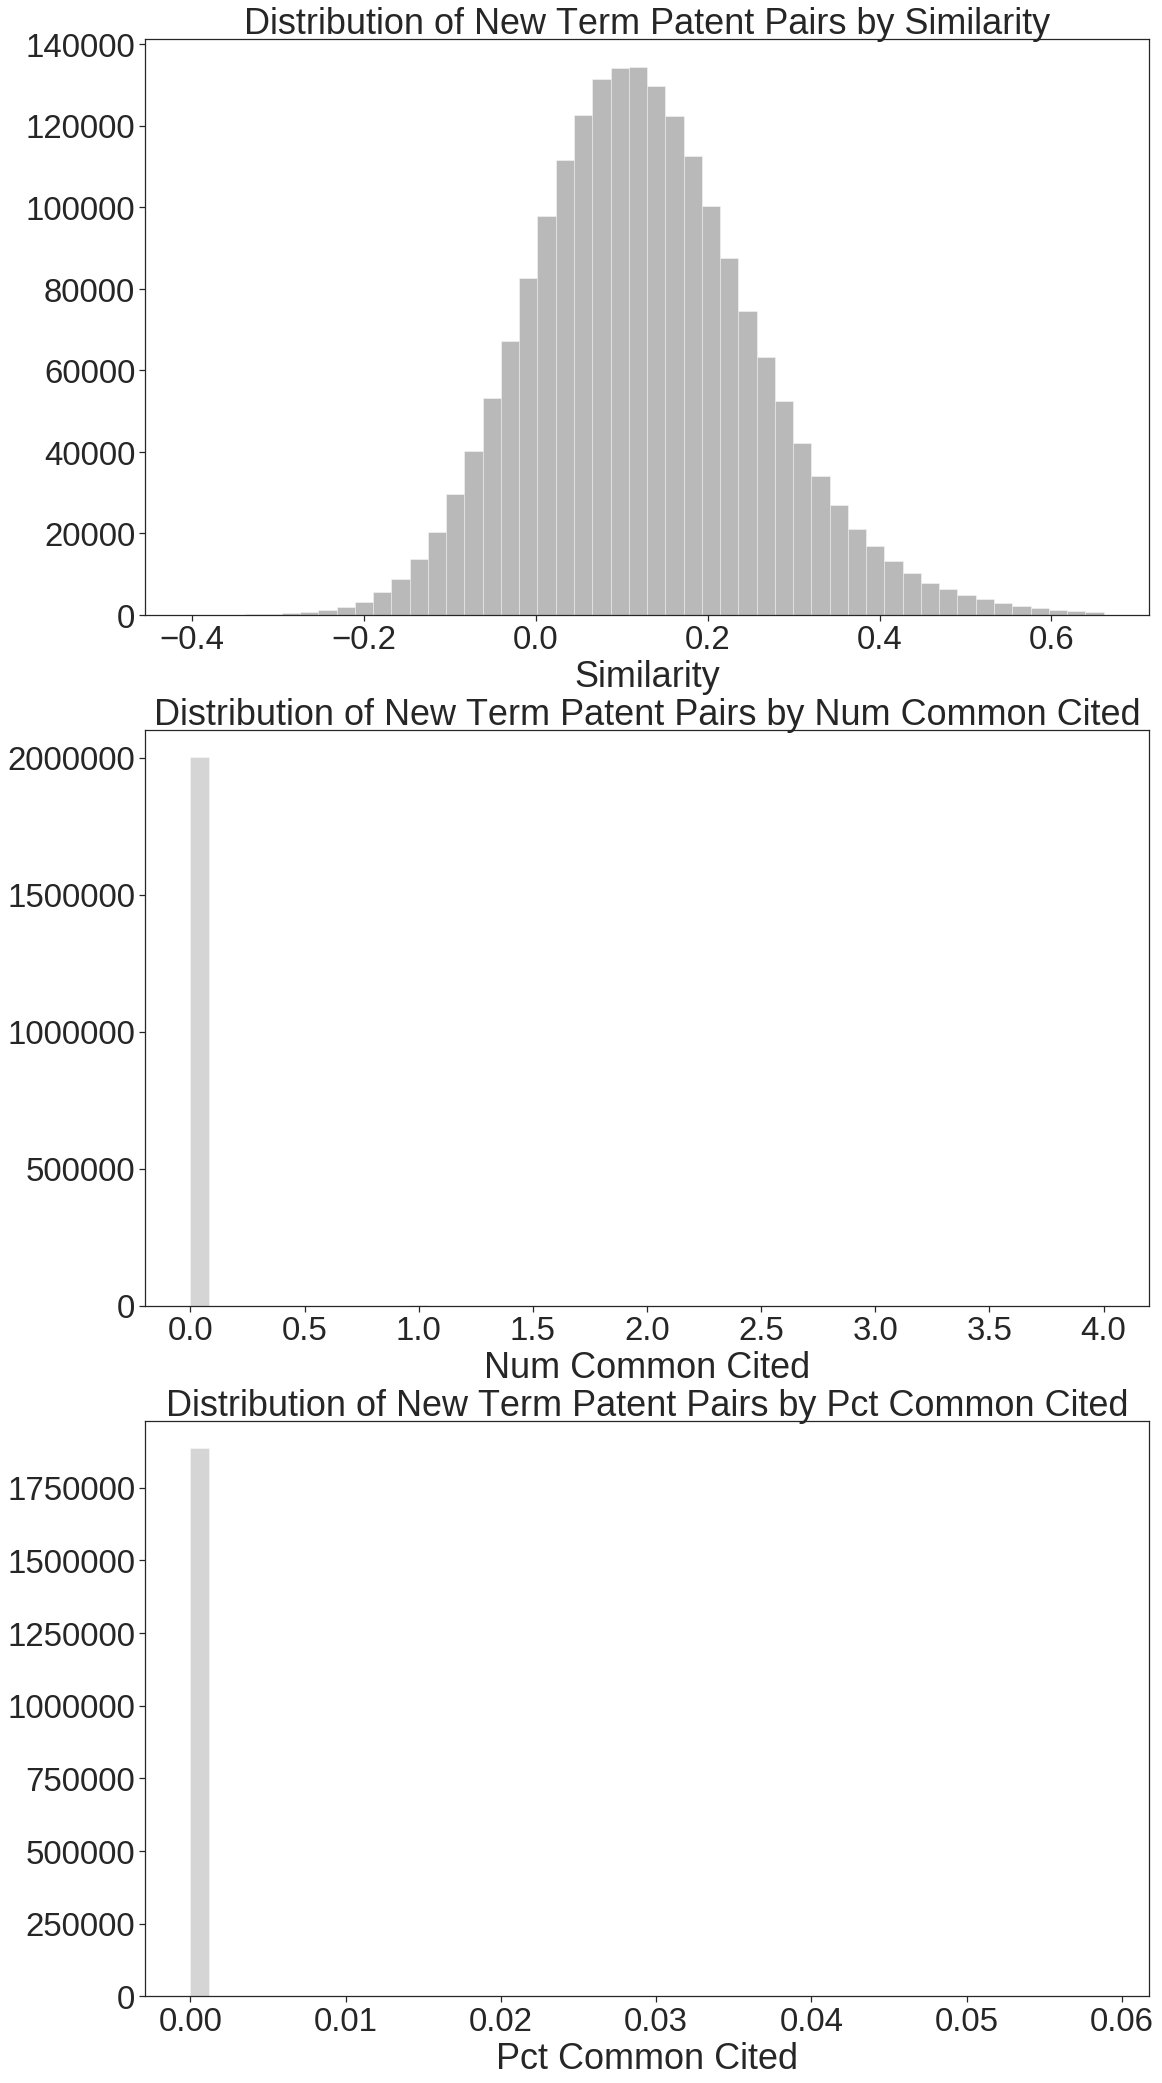

In [29]:
%matplotlib inline
sns.set(font_scale=3)
sns.set_style("ticks")
plt.rcParams["font.family"] = "Liberation Sans"
plt.rcParams.update({'font.size': 14})
plt.style.use('seaborn-muted')
# Set palette
gpal = sns.color_palette("Greys_r", 3).as_hex()
f, axarr = plt.subplots(3, 1, figsize=(18,36))

x1 = "sim_docvecs"
x2 = "num_common_cites"
x3 = "tp_pct_common_cites"

c_dict = {"sim_docvecs": "Similarity", "num_common_cites": "Num Common Cited", "tp_pct_common_cites": "Pct Common Cited"}
b = 50
df = sim

# Prune values within 4 SD
g1 = sns.distplot(df.loc[(df[x1] >= df[x1].mean()-4*df[x1].std())
                        &  (df[x1] <= df[x1].mean()+4*df[x1].std()), [x1]],
                                     bins=b, kde=False, color = gpal[0], ax = axarr[0])
axarr[0].set_xlabel(c_dict[x1])
axarr[0].set_title("Distribution of New Term Patent Pairs by "+c_dict[x1])

g2 = sns.distplot(df.loc[(df[x2] >= df[x2].mean()-4*df[x2].std())
                        &  (df[x2] <= df[x2].mean()+4*df[x2].std()), [x2]],
                  bins=b, kde=False, color = gpal[1],\
                 ax = axarr[1])
axarr[1].set_xlabel(c_dict[x2])
axarr[1].set_title("Distribution of New Term Patent Pairs by "+c_dict[x2])

g3 = sns.distplot(df.loc[(df[x3] >= df[x3].mean()-4*df[x3].std())
                        &  (df[x3] <= df[x3].mean()+4*df[x3].std()), [x3]],
                  bins=b, kde=False, color = gpal[1],\
                 ax = axarr[2])
axarr[2].set_xlabel(c_dict[x3])
axarr[2].set_title("Distribution of New Term Patent Pairs by "+c_dict[x3])

f.savefig("DataStore/2018-07-P3/ResultsGraphs/NewTerms-Dist.png", bbox_inches='tight')
del(f, axarr)

### Number of common citations by similarity

In [106]:
print(np.percentile(sim["sim_docvecs"], 99), np.percentile(sim["sim_docvecs"], 1))

0.3965587472824657 -0.15774481594482084


In [135]:
# Bins
import math

def sim_bin(x, a):
    try:
        return round(round(x / a) * a, -int(math.floor(math.log10(a))))
    except:
        return np.nan
    
sim["bin_sim_ldavecs"] = sim["sim_ldavecs"].apply(lambda x: sim_bin(x, 0.1))
sim["bin_sim_docvecs"] = sim["sim_docvecs"].apply(lambda x: sim_bin(x, 0.1))

# Upper and lower percentiles
sim.loc[sim["sim_docvecs"] >= 0.6, "bin_sim_docvecs"] = 0.6
sim.loc[sim["sim_docvecs"] <= -0.1, "bin_sim_docvecs"] = -0.1

In [136]:
%matplotlib inline
c_dict = pickle.load(open("DataStore/2018-06/col_names_dict.pkl", "rb"))

sns.set(font_scale=1.4)
sns.set_style("ticks")
plt.rcParams["font.family"] = "Liberation Sans"
plt.rcParams.update({'font.size': 20})
savepath = "DataStore/2018-07-P3/ResultsGraphs/"
def p1(x, y, hue, data, bars, order, ax): 
    g = sns.pointplot(x = x, y = y, hue = hue, 
                data = data, ci = bars, markers = ".", 
                order = order, dodge = True, errwidth = 1,
                palette = sns.color_palette("Greys_r", 3),
                n_boot = 100,      
                  ax = ax)
    sns.despine()
    return g

    
def p2(x, y, data, order, ax, conf_int = None):
    g = sns.pointplot(x=x, y=y, data = data, ci = conf_int, join = True,
                 order = order, markers = ".", color="grey", ax = ax)
    sns.despine()
    return g

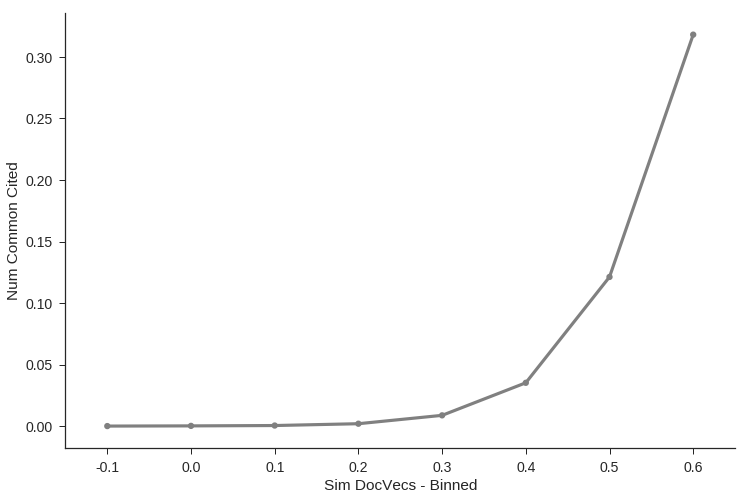

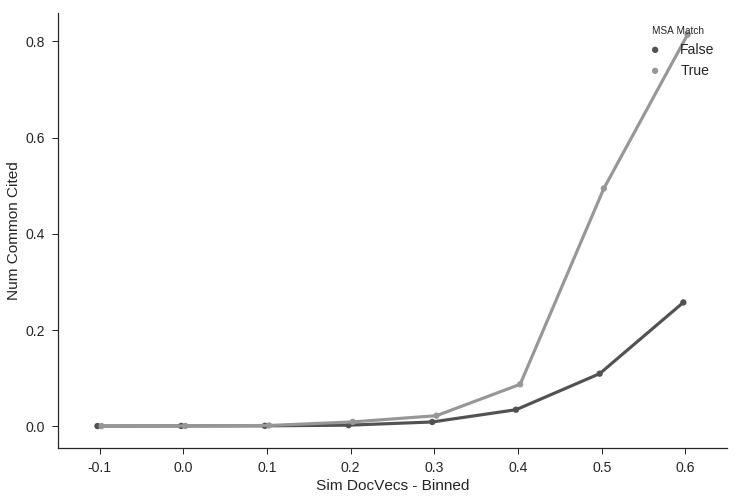

In [137]:
%matplotlib inline
x1 = "bin_sim_docvecs"
y1 = "num_common_cites"
order1 = None
conf_int1 = None
df = sim

fig, ax = plt.subplots(figsize=(12,8))
g3 = p2(x = x1, y = y1, order = order1, data = df, ax = ax, conf_int = conf_int1)
# plt.xticks(rotation="45")
ax.set_xlabel(c_dict[x1])
ax.set_ylabel(c_dict[y1])
plt.savefig(savepath+"NewTermsDV.png")
plt.show()
del(fig, ax)

# Hue: MSA Match
hue1 = "inv_msa_match"
fig, ax = plt.subplots(figsize=(12,8))
g3 = p1(x = x1, y = y1, order = order1, data = df, bars = conf_int1, hue = hue1, ax = ax)
g3.legend(loc='upper right', title = c_dict[hue1])
# plt.xticks(rotation="45")
ax.set_xlabel(c_dict[x1])
ax.set_ylabel(c_dict[y1])
plt.savefig(savepath+"NewTermsDV-MSAMatch.png")
plt.show()
del(fig, ax)

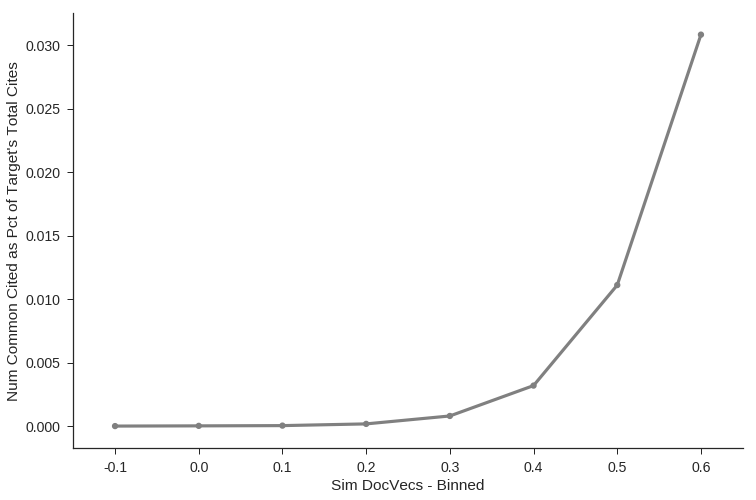

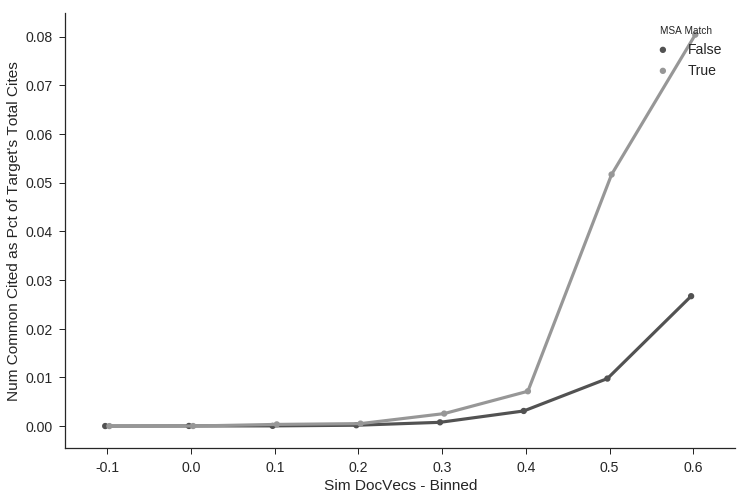

In [138]:
%matplotlib inline
x1 = "bin_sim_docvecs"
y1 = "tp_pct_common_cites"
order1 = None
conf_int1 = None
df = sim

fig, ax = plt.subplots(figsize=(12,8))
g3 = p2(x = x1, y = y1, order = order1, data = df, ax = ax, conf_int = conf_int1)
# plt.xticks(rotation="45")
ax.set_xlabel(c_dict[x1])
ax.set_ylabel(c_dict[y1])
plt.savefig(savepath+"NewTermsDV-PctCite.png")
plt.show()
del(fig, ax)

# Hue: MSA Match
hue1 = "inv_msa_match"
fig, ax = plt.subplots(figsize=(12,8))
g3 = p1(x = x1, y = y1, order = order1, data = df, bars = conf_int1, hue = hue1, ax = ax)
g3.legend(loc='upper right', title = c_dict[hue1])
# plt.xticks(rotation="45")
ax.set_xlabel(c_dict[x1])
ax.set_ylabel(c_dict[y1])
plt.savefig(savepath+"NewTermsDV-MSAMatch-PctCite.png")
plt.show()
del(fig, ax)